In [112]:
import pandas as pd
import spacy
import steamreviews
import json
import csv
import os
import glob
import json
import matplotlib.pyplot as plt
import nltk
import wordcloud
from wordcloud import WordCloud
import re
import plotly
import seaborn as sns
import stanza
import string 

from pandas.io.json import json_normalize
from nltk.corpus import stopwords
from tqdm.notebook import trange, tqdm
from sklearn.cluster import KMeans

## Reviews download
https://pypi.org/project/steamreviews/

In [113]:
dir_name = "data"
reviews_jsons = glob.glob(f"{dir_name}/*")
reviews_jsons

['data\\review_1150690.json',
 'data\\review_1172620.json',
 'data\\review_1341290.json',
 'data\\review_1515210.json',
 'data\\review_210970.json',
 'data\\review_219150.json',
 'data\\review_219890.json',
 'data\\review_250320.json',
 'data\\review_257510.json',
 'data\\review_262060.json',
 'data\\review_289070.json',
 'data\\review_294100.json',
 'data\\review_304430.json',
 'data\\review_394360.json',
 'data\\review_400.json',
 'data\\review_427520.json',
 'data\\review_460950.json',
 'data\\review_550.json',
 'data\\review_620.json',
 'data\\review_632470.json',
 'data\\review_646570.json',
 'data\\review_736260.json',
 'data\\review_860510.json']

In [114]:
title_dict = {"219150": "Hotline Miami",
              "1172620" : "Sea of Thieves",
              "460950" : "Katana ZERO",
              "262060" : "Darkest Dungeon",
              "250320" : "The Wolf Among Us",
              "210970" : "The Witness",
              "620" : "Portal 2",
              "736260" : "Baba Is You",
              "219890" : "Antichamber",
              "289070" : "Sid Meier's Civilization VI",
              "427520" : "Factorio",
              "257510" : "The Talos Principle",
             "304430" : "INSIDE",
             "400" : "Portal",
             "394360" : "Hearts of Iron IV",
             "632470" : "Disco Elysium",
             "294100" : "RimWorld",
              "646570" : "Slay the Spire",
              "1150690" : "Omori",
              "1341290" : "We Were Here Forever",
              "1515210" : "The Past Within",
              "860510" : "Little Nightmares II",
              "550" : "Left 4 Dead 2"}

In [115]:
genre_dict = {"219150": "A",
              "1172620" : "A",
              "460950" : "A",
              "262060" : "R",
              "250320" : "R",
              "210970" : "P",
              "620" : "P",
              "736260" : "P",
              "219890" : "P",
              "289070" : "S",
              "427520" : "S",
              "257510" : "P",
              "304430" : "P",
             "400" : "P",
             "394360" : "S",
             "632470" : "R",
             "294100" : "S",
             "646570" : "R",
             "1150690" : "R",
             "1341290" : "P",
             "1515210" : "P",
             "860510" : "P",
             "550" : "A"}

In [116]:
data_list = []
for i in reviews_jsons:
    with open(i, encoding = "utf-8") as json_file:
        json_data = json.load(json_file)
        reviews = json_data['reviews']
        file_name = json_file.name.split('.')[0].split('_')[1]
        for key in reviews.keys():
            data_list.append([title_dict.get(file_name),genre_dict.get(file_name),reviews[key]['author']['steamid'], reviews[key]['votes_up'], 
                          reviews[key]['review'], reviews[key]['weighted_vote_score'], reviews[key]['voted_up'],
                          reviews[key]['author']['num_games_owned'], reviews[key]['author']['playtime_at_review'],
                          reviews[key]['author']['num_reviews'], 
                          reviews[key]["timestamp_created"] ])
df = pd.DataFrame(data_list, columns = ["title", "genre","steamid", "votes_up", "review", "weighted_vote_score", "voted_up",
                                        "num_games_owned", "playtime_at_review", "num_reviews", "timestamp_created"])

In [117]:
df.sample(frac=0.3).head()

,title,genre,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created
18988,Portal,P,76561199230474412,1,title didnt lie,0.510676145553588867,True,42,250,14,1679750238
10215,Sid Meier's Civilization VI,S,76561198803439706,1,boats n stuff,0.525862038135528564,True,105,191,17,1677476027
30258,Disco Elysium,R,76561198257786254,144,I don't write reviews for games very often. Us...,0.886660575866699219,True,167,2918,7,1647048199
31788,Little Nightmares II,P,76561198402206100,1,Binge completed the two games in the series. I...,0.523809552192687988,True,258,361,45,1672601557
25942,Portal 2,P,76561198086884516,2,A jam-packed continuation of when Valve tried ...,0.545454561710357666,True,42,6412,6,1669159311


In [118]:
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], unit='s')

## Preprocessing

1. Braki danych
2. Usunięcie duplikatów
4. Usunięcie recenzjii krótszych niż 3 słowa
9. Usunięcie znaków spcjalnych 
10. "Text lowering"
6. Usunięcie znaków interpunkcyjnych i liczb
8. Usunięcie tytułów gier z recenzji
7. Tokenizacja
8. Part-of-speech tagging
9. Lematyzacja

#### Braki danych

In [119]:
df.isna().sum()

title                  0
genre                  0
steamid                0
votes_up               0
review                 0
weighted_vote_score    0
voted_up               0
num_games_owned        0
playtime_at_review     0
num_reviews            0
timestamp_created      0
dtype: int64

#### Usunięcie duplikatów

In [120]:
df.duplicated(subset='review').sum()

2580

In [121]:
df[df.duplicated(subset='review')].sample(20)

,title,genre,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created
26694,Portal 2,P,76561199127956108,1,Very good game,0.523809552192687988,True,0,517,10,2023-03-07 22:02:01
3871,Sea of Thieves,A,76561198405296924,1,W game,0.523809552192687988,True,20,266,4,2023-03-16 13:33:59
13527,RimWorld,S,76561198115576796,1,yes,0.523809552192687988,True,241,38868,10,2022-10-15 03:25:42
15495,Hearts of Iron IV,S,76561198272597801,1,best game ever,0.527272701263427734,True,0,3057,22,2023-01-10 04:59:47
7661,Hotline Miami,A,76561199408749881,1,W game,0.523809552192687988,True,0,286,4,2023-05-26 07:51:12
4164,Sea of Thieves,A,76561199060288350,1,yes,0.523809552192687988,True,13,453,4,2023-01-13 15:15:38
2021,Omori,R,76561199102683728,1,omoi,0.502074718475341797,True,0,1545,2,2022-12-09 20:15:43
25477,Left 4 Dead 2,A,76561199157368245,1,gg,0.503866016864776611,True,27,891,4,2022-12-02 00:39:22
1945,Omori,R,76561199148276910,1,sad,0.504716992378234863,True,0,1112,5,2023-07-05 03:13:52
14303,RimWorld,S,76561199123002182,1,very gud,0.503267943859100342,True,0,4612,8,2023-06-29 15:44:21


In [122]:
(df.duplicated(subset='review') == False).sum()

29492

In [123]:
df = df[df.duplicated(subset='review') == False]

In [124]:
df.duplicated(subset='review').sum()

0

#### Długość recenzji

In [125]:
df["temp_review_len"] = df["review"].apply(lambda x: x.split(" ").__len__())
df["temp_review_len"].describe()

count    29492.000000
mean        54.191984
std        135.354534
min          1.000000
25%          5.000000
50%         13.000000
75%         39.000000
max       3997.000000
Name: temp_review_len, dtype: float64

In [126]:
df[df["temp_review_len"] < 4].groupby(by=["genre"]).count()

,title,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created,temp_review_len
genre,,,,,,,,,,,
A,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659
P,852,852,852,852,852,852,852,852,852,852,852
R,798,798,798,798,798,798,798,798,798,798,798
S,1140,1140,1140,1140,1140,1140,1140,1140,1140,1140,1140


In [127]:
df = df[df["temp_review_len"] >= 3]

In [128]:
suma = 0
for i in df["temp_review_len"]:
    suma += i

In [129]:
print("Ilość słów:", suma,
     "Ilość recenzji:", len(df["temp_review_len"]))

Ilość słów: 1593992 Ilość recenzji: 26663


In [130]:
df = df.drop(["temp_review_len"], axis=1)

### Wordcloud

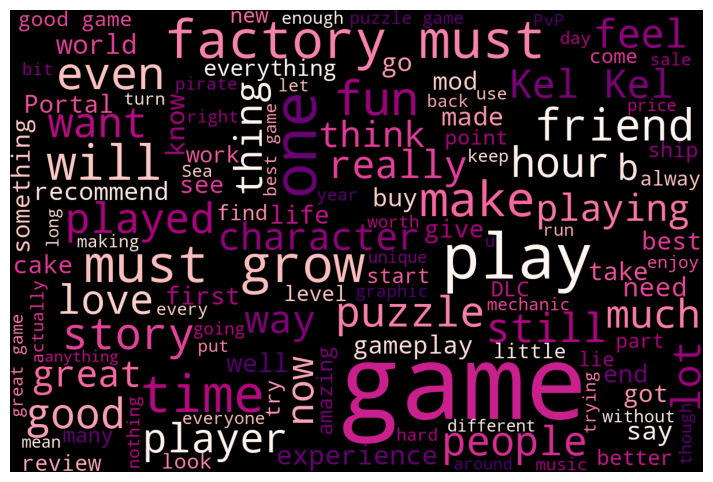

In [131]:
txt = ' '.join(i for i in df["review"])
wordcloud = WordCloud(max_font_size = 180,
                max_words = 120,
                width = 1200,
                height = 800,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

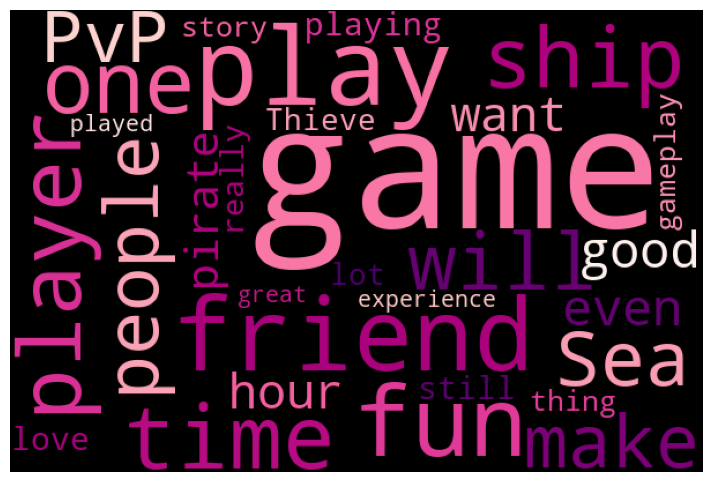

In [132]:
txt = ' '.join(i for i in df[df['genre'] == "A"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

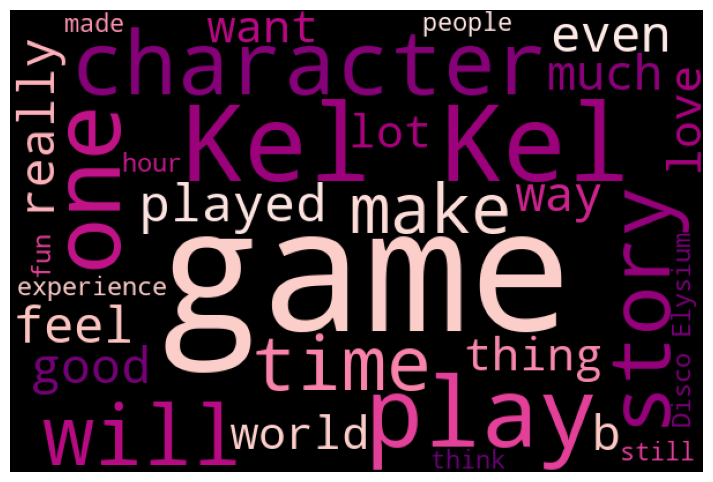

In [133]:
txt = ' '.join(i for i in df[df['genre'] == "R"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

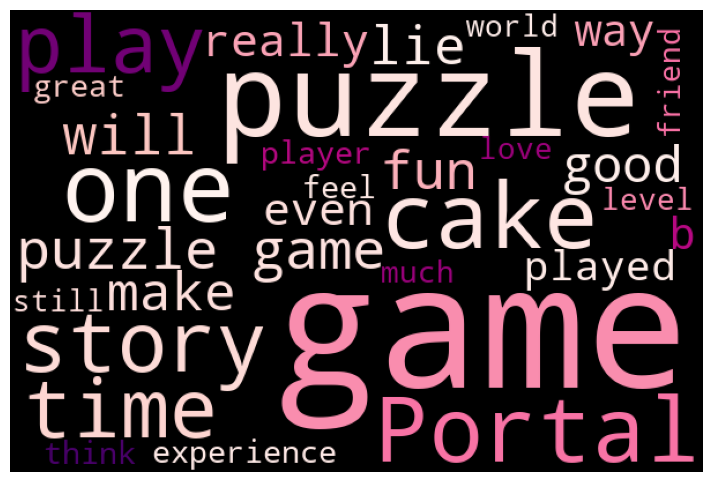

In [134]:
txt = ' '.join(i for i in df[df['genre'] == "P"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

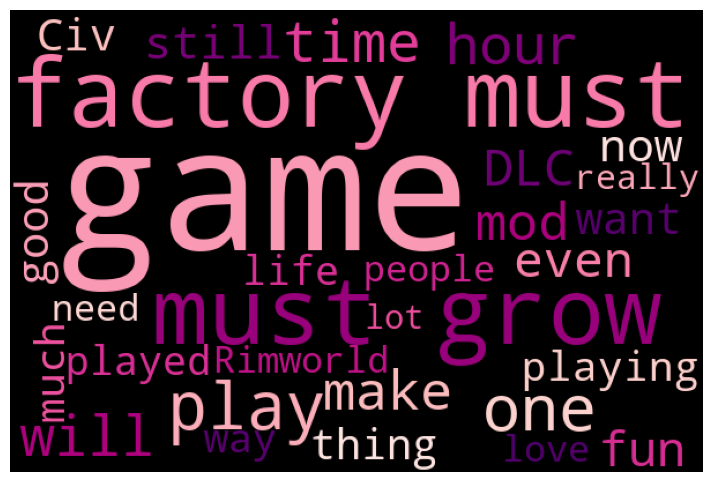

In [135]:
txt = ' '.join(i for i in df[df['genre'] == "S"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

#### Usunięcie znaków, text lowering

In [136]:
df["review"] = df["review"].str.replace(r"\[.*?\]|\n|[^\x00-\x7F]+", "", regex=True).str.lower()

In [137]:
df["review"].sample(10)

10541    this game made my penis explode into a million...
22810    me and my friends had a fight over the med kit...
2599     take in some great sights! explore the s-- sto...
7413                           i like hurting other people
28103    if this game was a person, i would have a lovi...
20822    ---{ graphics }--- you forget what reality is ...
29472    completely engrossing, well-paced, and phenome...
19761    the legendary factory building game, where the...
10697    its civ its great as long as you have two days...
22888    one of if not the best zombie game ever made t...
Name: review, dtype: object

#### Usunięcie znaków interpunkcyjnych i liczb

In [138]:
df["review"] = df["review"].str.replace(r"[0-9]", "", regex=True)

In [139]:
df["review"] = df["review"].str.replace('['  + string.punctuation + ']', "", regex =True)

In [140]:
df["review"].sample(5)

9288     absolutely stunning love the dungeon crawling ...
2540     there is no structure to help the player to gr...
30062    story  immersion  soundtrack  world in game  c...
21393    absolutely unexpected plot at least for me i a...
26430                                      look up chell r
Name: review, dtype: object

#### Usunięcie tytułów gier z recenzji

In [141]:
for value in title_dict.values():
    df["review"] = df["review"].str.replace(value.lower(), "")

#### Tokenizacja

In [142]:
df["tokenized"] = df["review"].apply(nltk.word_tokenize)

In [143]:
df["tokenized"].sample(15)

8015     [like, a, vacation, trip, to, mexico, this, ga...
15806                        [i, want, to, kill, my, self]
18362    [very, fun, has, multiple, puzzles, including,...
14626    [crazy, i, was, crazy, once, they, locked, me,...
12230    [recommended, to, fans, of, animal, crossingin...
31056    [it, feels, like, wasting, time, mostly, skill...
9901                                   [i, like, to, nuke]
14121         [whelp, its, addictive, ill, give, it, that]
25282                 [the, best, game, ive, ever, played]
3664     [what, did, the, ocean, say, to, the, pirate, ...
25721    [oh, boy, i, love, getting, slapped, off, a, b...
3296     [we, sailin, with, the, teamwere, headin, up, ...
18429    [very, good, game, good, gameplay, good, endin...
29274    [the, world, of, this, game, is, simply, beaut...
14968    [this, game, is, an, experience, it, tells, a,...
Name: tokenized, dtype: object

### Stopwords

In [144]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
english_stopwords = stopwords.words('english')
english_stopwords_cleaned = [word.replace("'", "") for word in english_stopwords]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [145]:
new_column = []
for row in df["tokenized"]:
    new_row = [word for word in row if word[0] not in english_stopwords_cleaned]
    new_column.append(new_row)
df["final_review"] = new_column

## Describe

In [146]:
df.dtypes

title                          object
genre                          object
steamid                        object
votes_up                        int64
review                         object
weighted_vote_score            object
voted_up                         bool
num_games_owned                 int64
playtime_at_review              int64
num_reviews                     int64
timestamp_created      datetime64[ns]
tokenized                      object
final_review                   object
dtype: object

In [147]:
df["weighted_vote_score"] = pd.to_numeric(df["weighted_vote_score"])

In [148]:
df["voted_up"] = pd.to_numeric(df["voted_up"])

In [149]:
df.describe()

,votes_up,weighted_vote_score,num_games_owned,playtime_at_review,num_reviews
count,26663.000000,26663.000000,26663.000000,2.666300e+04,26663.000000
mean,31.715148,0.570098,140.866707,1.309372e+04,21.467689
std,173.097223,0.109932,538.652824,4.720263e+04,59.809381
min,0.000000,0.500000,0.000000,5.000000e+00,1.000000
25%,1.000000,0.521739,0.000000,5.350000e+02,3.000000
50%,1.000000,0.523810,0.000000,1.800000e+03,8.000000
75%,3.000000,0.545180,113.000000,7.111500e+03,20.000000
max,9568.000000,0.987843,22780.000000,1.890626e+06,3419.000000


C:\Users\marty\AppData\Local\Temp\ipykernel_5264\2159658958.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


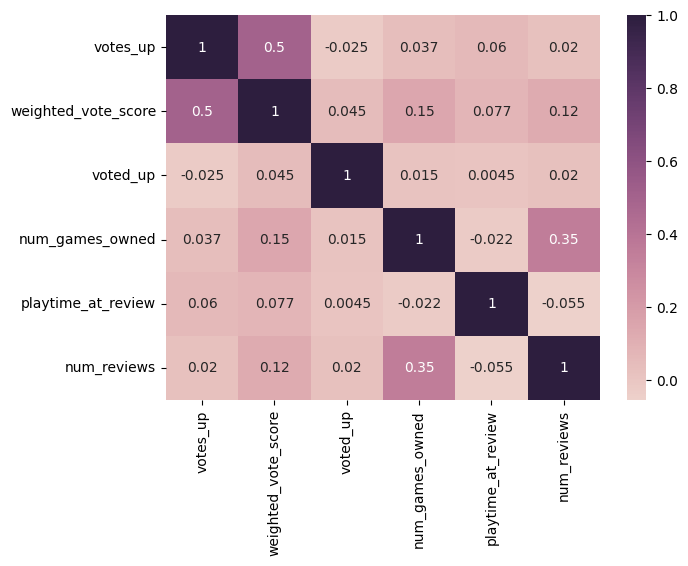

In [150]:
corr = df.corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr, cmap=sns.cubehelix_palette(as_cmap=True),annot=True)
plt.show()

## Wykresy

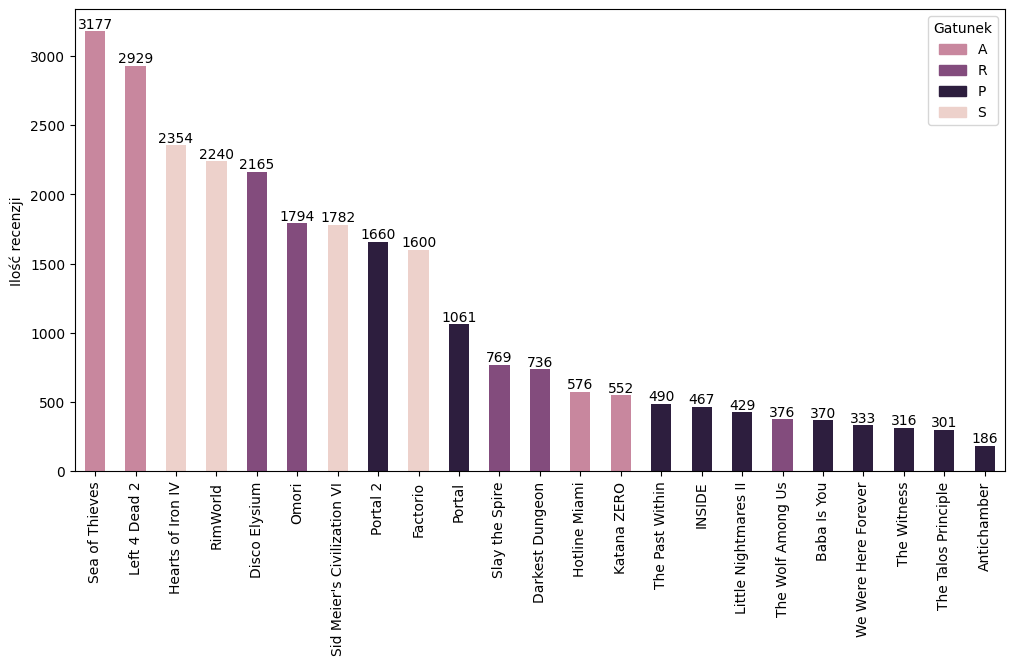

In [151]:
value_counts_title = df["title"].value_counts()
genre_colors = {"A": sns.cubehelix_palette(4)[1], "R": sns.cubehelix_palette(4)[2], "P": sns.cubehelix_palette(4)[3], 
                "S": sns.cubehelix_palette(4)[0]}
df['color'] = df['genre'].map(genre_colors)
colors = [df.loc[df['title'] == title]['color'].iloc[0] for title in value_counts_title.index]

plt.figure(figsize=(12, 6))
x = value_counts_title.plot(kind = "bar", color = colors)
plt.ylabel("Ilość recenzji")
plt.xticks(rotation = 90)
for i, count in enumerate(value_counts_title):
    x.text(i, count, count, va = "bottom", ha = "center")

handles = [plt.Rectangle((0,0), 1,1, color=genre_colors[label]) for label in genre_colors]
plt.legend(handles, genre_colors.keys(), title="Gatunek", loc="upper right")


plt.show()
df = df.drop(["color"], axis=1)

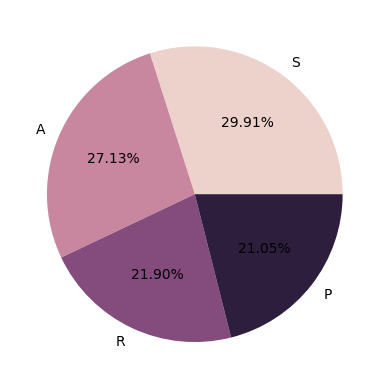

In [152]:
value_counts_genre = df["genre"].value_counts()
colors = sns.cubehelix_palette(4)
x = plt.pie(value_counts_genre, labels = value_counts_genre.index, colors=colors, autopct='%1.2f%%')
plt.show()

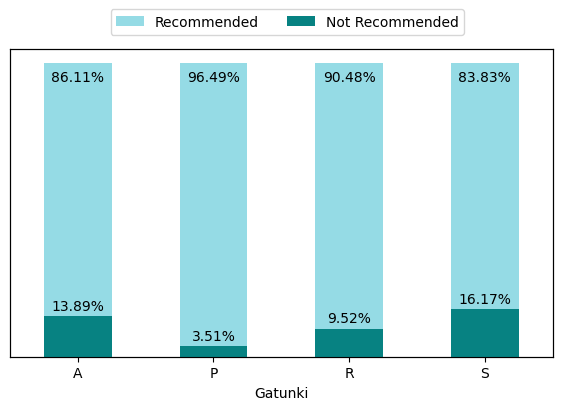

In [153]:
value_counts_recommendation_genre = df.groupby('genre').voted_up.value_counts().unstack(0)
percentage_pos = value_counts_recommendation_genre.iloc[1] / (value_counts_recommendation_genre.iloc[1] + value_counts_recommendation_genre.iloc[0]) * 100 
percentage_neg = value_counts_recommendation_genre.iloc[0] / (value_counts_recommendation_genre.iloc[0] + value_counts_recommendation_genre.iloc[1]) * 100 

total_count = percentage_pos + percentage_neg

def addlabels_neg(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] + 2, f"{x[i]:.2f}%",  ha = "center")

def addlabels_pos(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] - 6, f"{y[i]:.2f}%",  ha = "center")

fig, ax1 = plt.subplots(figsize=(7, 4))
ax2 = ax1.twinx()

total_count.plot(kind="bar", color="#95DBE5FF",  label="Recommended")
percentage_neg.plot(kind="bar", color="#078282FF", label="Not Recommended")

ax1.set_xlabel("Gatunki")
ax1.tick_params(axis="y", left=False, labelleft=False)
ax2.tick_params(axis="y", right=False, labelright=False)

addlabels_neg(percentage_neg, total_count) 
addlabels_pos(total_count, percentage_pos) 

plt.legend(bbox_to_anchor=(0.85, 1.15), ncol=2)
plt.show()

## Dependency parser test

In [154]:
test = [df["final_review"][6543], df["final_review"][4534], df["final_review"][12345], df["final_review"][12354],
        df["final_review"][1925], df["final_review"][1067],df["final_review"][22951],df["final_review"][2231],
       ["not","fun", "gameplay"], df["tokenized"][832], df["final_review"][21], df["tokenized"][27061],
       df["final_review"][11088], df["final_review"][3171], df["final_review"][7834], df["final_review"][20180],
       df["final_review"][6697], df["final_review"][893]]

In [155]:
import stanza
nlp = stanza.Pipeline('en', tokenize_pretokenized=True) 
doc = nlp(test)

2024-04-24 13:33:44 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-04-24 13:33:44 INFO: Downloaded file to C:\Users\marty\stanza_resources\resources.json
2024-04-24 13:33:45 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2024-04-24 13:33:45 INFO: Using device: cuda
2024-04-24 13:33:45 INFO: Loading: tokenize
2024-04-24 13:33:45 INFO: Loading: mwt
2024-04-24 13:33:45 INFO: Loading: pos
2024-04-24 13:33:46 INFO: Loading: lemma
2024-04-24 13:33:46 INFO: Loading: constituency
2024-04-24 13:33:46 INFO: Loading: depparse
2024-04-24 13:33:47 INFO: Loading: sentiment
2024-04-24 13:33:47 INFO: Loading: ne

In [156]:
dependency_list = []
for dependency in doc.sentences[13].dependencies:
    dependency_list.append([dependency[2].text, dependency[0].id, dependency[1]])
    
for i in range(0, len(dependency_list)):
    if (int(dependency_list[i][1]) != 0):
        dependency_list[i][1] = test[13][(int(dependency_list[i][1]) - 1)]

print(*dependency_list[:20], sep='\n')

['crewing', 0, 'root']
['game', 'value', 'compound']
['value', 'crewing', 'obj']
['likely', 'crewing', 'advmod']
['worthless', 'crewing', 'xcomp']
['real', 'crewing', 'xcomp']
['but', 'play', 'cc']
['can', 'play', 'aux']
['play', 'crewing', 'conj']
['player', 'play', 'obj']
['but', 'want', 'cc']
['cant', 'want', 'aux']
['really', 'want', 'advmod']
['want', 'crewing', 'conj']
['like', 'graphics', 'discourse']
['game', 'fun', 'compound']
['fun', 'graphics', 'amod']
['graphics', 'want', 'obj']
['basic', 'want', 'xcomp']
['but', 'have', 'cc']


In [157]:
feature_list = []
feature_opinion_list = [] 

for dependency in doc.sentences[13].dependencies:
    if dependency[2].xpos == "RB":
        opinion_word = dependency[2]
        rb_adj = dependency[0]
        
    if (dependency[2].xpos in ["NN", "NNS", "JJ", "JJS", "JJR"]) and (dependency[1] in ["amod"]):
        if dependency[0] == rb_adj or dependency[2] == rb_adj:
            if dependency[2].xpos in ["JJS", "JJR"]:
                result_dict = {'feature': dependency[0].lemma, 'opinion': opinion_word.text + " " + dependency[2].text}
            else:
                result_dict = {'feature': dependency[0].lemma, 'opinion': opinion_word.text + " " + dependency[2].lemma}     
        else:
            if dependency[2].xpos in ["JJS", "JJR"]:
                result_dict = {'feature': dependency[0].lemma, 'opinion': dependency[2].text}
            else:
                result_dict = {'feature': dependency[0].lemma, 'opinion': dependency[2].lemma}  

        feature_list.append(dependency[0].lemma)
        feature_opinion_list.append(result_dict)

print(f'Feature list: {feature_list}')
print(f'Feature-opinion list: {feature_opinion_list}')

Feature list: ['graphic', 'beauty', 'player', 'player', 'player', 'guide', 'reward', 'reward', 'reward']
Feature-opinion list: [{'feature': 'graphic', 'opinion': 'fun'}, {'feature': 'beauty', 'opinion': 'real'}, {'feature': 'player', 'opinion': 'unbalanced'}, {'feature': 'player', 'opinion': 'janky'}, {'feature': 'player', 'opinion': 'human'}, {'feature': 'guide', 'opinion': 'necessary'}, {'feature': 'reward', 'opinion': 'risky'}, {'feature': 'reward', 'opinion': 'lowest'}, {'feature': 'reward', 'opinion': 'highest'}]


## Dependency parser final

In [158]:
with open('opinions.json', 'r') as file:
    dct = json.load(file)

In [159]:
feature_list = []

for i in range(len(df)):
    index = str(i)  
    feature = dct.get(index)
    if feature is None:
        feature_list.append([])
    else:
        feature_list.append(feature)

df["feature"] = feature_list

In [160]:
df = df[df["feature"].apply(lambda x: len(x) > 0)]

## Word embedding

## Correct misspeld words

In [161]:
words = []
for i in df["feature"]:
    for j in i:
        words.append(j["feature"])

## Similarity

### Word counts

In [162]:
unique_words = list(set(words))

In [163]:
word_counts = pd.DataFrame([[i, len([q for q in words if q==i])] for i in unique_words], 
              columns=['word', 'count']).sort_values('count', ascending=False)

## K-means

In [164]:
popular_words = word_counts[word_counts['count']>=15]["word"].to_list()
nlp = spacy.load('en_core_web_md')
tokens = [nlp(word) for word in popular_words]
word_vectors = pd.DataFrame([i.vector for i in tokens])

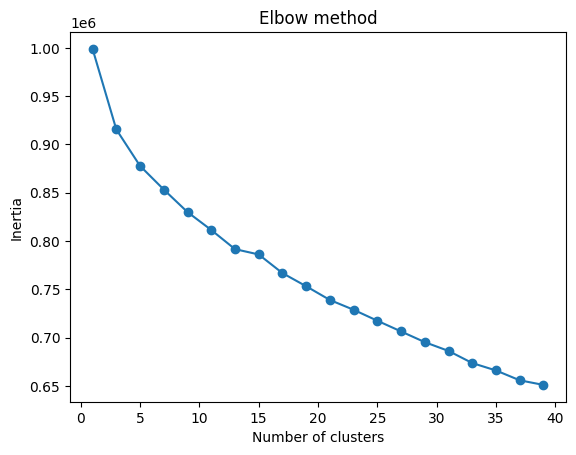

In [165]:
inertias = []
for i in range(1,40, 2):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init = 100, random_state=3)
    kmeans.fit(word_vectors)
    inertias.append(kmeans.inertia_)
    
plt.plot(range(1,40, 2), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [166]:
kmeans = joblib.load('kmeans_model.pkl')

In [167]:
clustered_words = joblib.load('kmeans_clustered_data.pkl')

In [168]:
clustered_words

,word,cluster
0,game,23
1,puzzle,2
2,experience,36
3,gameplay,23
4,play,25
...,...,...
392,patch,10
393,behavior,36
394,fortress,16
395,formula,36


In [169]:
cluster_1_words = clustered_words.loc[clustered_words['cluster'] == 38, 'word']
print(cluster_1_words)

Series([], Name: word, dtype: object)


In [171]:
graphics = []
people = []
price = []
feelings = []
combat = []
bug = []
all_clusters = []
backstory = []
universe = []
game = []

for word, cluster in zip(clustered_words['word'], clustered_words['cluster']):
    if cluster in [3, 20]:
        graphics.append(word)
        all_clusters.append(word)
    elif cluster in [5]:
        people.append(word)
        all_clusters.append(word)
    elif cluster in [6]:
        price.append(word)
        all_clusters.append(word)
    elif cluster in [7, 32, 37]:
        feelings.append(word)
        all_clusters.append(word)
    elif cluster in [8, 26, 34]:
        combat.append(word)
        all_clusters.append(word)
    elif cluster in [9]:
        bug.append(word)
        all_clusters.append(word)
    elif cluster in [11, 29, 35]:
        all_clusters.append(word)
    elif cluster in [15, 33]:
        backstory.append(word)
        all_clusters.append(word)
    elif cluster in [16, 19]:
        universe.append(word)
        all_clusters.append(word)
    elif cluster in [23, 25, 31]:
        game.append(word)
        all_clusters.append(word)

print("All clusters:", all_clusters)

Graphics: ['box', 'button', 'page', 'ui']
People: ['guy', 'kid', 'boy', 'woman', 'girl']
Price: ['price', 'rate', 'cost']
Feelings: ['love', 'care', 'humor', 'vibe', 'joy', 'risk', 'gem', 'quirk', 'charm']
Combat: ['enemy', 'war', 'weapon', 'raid', 'gun', 'fire', 'raider', 'bomb']
Bug: ['bug', 'glitch']
All clusters: ['game', 'gameplay', 'play', 'player', 'price', 'love', 'character', 'world', 'lot', 'life', 'bit', 'colony', 'room', 'bug', 'civ', 'enemy', 'pvp', 'guy', 'need', 'colonist', 'war', 'cant', 'hero', 'fan', 'rpg', 'genre', 'kid', 'city', 'horror', 'weapon', 'plot', 'playing', 'empire', 'boy', 'name', 'gamer', 'episode', 'book', 'wall', 'god', 'country', 'raid', 'care', 'gaming', 'planet', 'humor', 'video', 'landscape', 'cutscene', 'havent', 'gun', 'classic', 'fps', 'lore', 'woman', 'can', 'vibe', 'joy', 'box', 'universe', 'fire', 'chapter', 'family', 'era', 'girl', 'legend', 'pc', 'novel', 'risk', 'gem', 'button', 'raider', 'glitch', 'body', 'quirk', 'protagonist', 'page', '

In [172]:
uncategorized_words = []
for i in tokens:
    if str(i) not in all_clusters:
        uncategorized_words.append(i)

In [173]:
uncategorized_words

[puzzle,
 experience,
 way,
 hour,
 person,
 fun,
 level,
 review,
 graphic,
 content,
 friend,
 part,
 challenge,
 grind,
 community,
 point,
 update,
 feature,
 end,
 nothing,
 work,
 problem,
 event,
 factory,
 place,
 pirate,
 NASA,
 line,
 fight,
 element,
 playthrough,
 quest,
 environment,
 battle,
 everything,
 run,
 visual,
 effect,
 ending,
 job,
 combat,
 concept,
 building,
 lake,
 choice,
 reason,
 resource,
 version,
 piece,
 look,
 boss,
 campaign,
 civilization,
 crew,
 feel,
 control,
 feeling,
 leader,
 use,
 possibility,
 number,
 hand,
 fact,
 everyone,
 week,
 requirement,
 question,
 voice,
 replayability,
 change,
 workshop,
 word,
 force,
 base,
 wish,
 robot,
 reward,
 quality,
 luck,
 party,
 example,
 unit,
 usage,
 encounter,
 hope,
 note,
 effort,
 emotion,
 eye,
 value,
 couple,
 chamber,
 history,
 release,
 progress,
 night,
 pack,
 wait,
 figure,
 chance,
 course,
 case,
 rule,
 zomby,
 victory,
 narrative,
 journey,
 buy,
 guess,
 heart,
 valve,
 worth

In [ ]:
nlp = spacy.load('en_core_web_md')
tokens = [nlp(word) for word in uncategorized_words]
word_vectors = pd.DataFrame([i.vector for i in tokens])

## Categories